# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

# Configuration

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 25
batch_size = 100
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Dataset

In [8]:
char2ind = {}
def data_init():
    global char2ind
    with open("../wikitext-103/train.txt", encoding="utf8") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("../wikitext-103/valid.txt", encoding="utf8") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("../wikitext-103/test.txt", encoding="utf8") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return torch.tensor(trn,dtype=torch.int64), torch.tensor(vld,dtype=torch.int64), torch.tensor(tst,dtype=torch.int64), len(words)

def findWordByToken(iToken):
    for word, toekn in char2ind.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if toekn == iToken:
            return word
    return ''

In [9]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

In [10]:
train_tokens_voc , valid_tokens_voc , test_tokens_voc , vocab_size= data_init()

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [11]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output

# Train

## Learning Functions

In [12]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [13]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [14]:
embedding_dim = 700
hidden_dim = 700
num_layers = 1
dropout_rate = 0.25

loadModel = 0

if loadModel == 1:
    model_path = 'model.pt'
    model = torch.load(model_path)

    data  = pd.read_csv("./learningCurve.csv")

    loss_train_hist = data['loss_train'].to_list()
    loss_valid_hist = data['loss_validation'].to_list()

    per_train_hist = data['perplexity_train'].to_list()
    per_valid_hist = data['perplexity_validation'].to_list()

    lr_train_hist = []

    best_perplexity_valid = torch.inf
    epoch_counter = len(data)

else:
    model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
    loss_train_hist = []
    loss_valid_hist = []

    per_train_hist = []
    per_valid_hist = []

    lr_train_hist = []

    best_perplexity_valid = torch.inf
    epoch_counter = 0

model = model.to(device)
model

H_LSTM(
  (embedding): Embedding(267735, 700)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(700, 700, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(700, 700, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(700, 700, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=700, out_features=267735, bias=True)
)

In [15]:
num_trainable_params(model)

386.873535

## Learning Loop

In [16]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [17]:
num_epochs = 300
max_lr_dec = 5
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

  0%|          | 0/41291 [00:00<?, ?batch/s]/tmp/ipykernel_4181/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)
Epoch 0: 100%|██████████| 41291/41291 [1:50:33<00:00,  6.22batch/s, loss=2.92, perplexity=inf] 


Valid: Loss = 1.151 Perplexity= 3.229, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 41291/41291 [1:50:21<00:00,  6.24batch/s, loss=1.13, perplexity=3.22]


Valid: Loss = 0.8187 Perplexity= 2.303, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 41291/41291 [1:50:18<00:00,  6.24batch/s, loss=0.93, perplexity=2.61] 


Valid: Loss = 0.7381 Perplexity= 2.12, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 41291/41291 [1:50:13<00:00,  6.24batch/s, loss=0.862, perplexity=2.43]


Valid: Loss = 0.7045 Perplexity= 2.048, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 41291/41291 [1:50:16<00:00,  6.24batch/s, loss=0.826, perplexity=2.34]


Valid: Loss = 0.6801 Perplexity= 1.998, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 41291/41291 [1:50:11<00:00,  6.25batch/s, loss=0.804, perplexity=2.29]


Valid: Loss = 0.6651 Perplexity= 1.967, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 41291/41291 [1:50:16<00:00,  6.24batch/s, loss=0.789, perplexity=2.25]


Valid: Loss = 0.6489 Perplexity= 1.935, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 41291/41291 [1:50:10<00:00,  6.25batch/s, loss=0.776, perplexity=2.22]


Valid: Loss = 0.6476 Perplexity= 1.932, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 41291/41291 [1:50:14<00:00,  6.24batch/s, loss=0.767, perplexity=2.2] 


Valid: Loss = 0.639 Perplexity= 1.915, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 41291/41291 [1:50:10<00:00,  6.25batch/s, loss=0.759, perplexity=2.18]


Valid: Loss = 0.6332 Perplexity= 1.904, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 41291/41291 [1:50:15<00:00,  6.24batch/s, loss=0.751, perplexity=2.16]


Valid: Loss = 0.6241 Perplexity= 1.886, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 41291/41291 [1:50:11<00:00,  6.25batch/s, loss=0.746, perplexity=2.15]


Valid: Loss = 0.6236 Perplexity= 1.885, LR = 0.5
Model Saved!



Epoch 12:  67%|██████▋   | 27543/41291 [1:13:33<36:42,  6.24batch/s, loss=0.741, perplexity=2.14]


KeyboardInterrupt: 

## Learning Curve

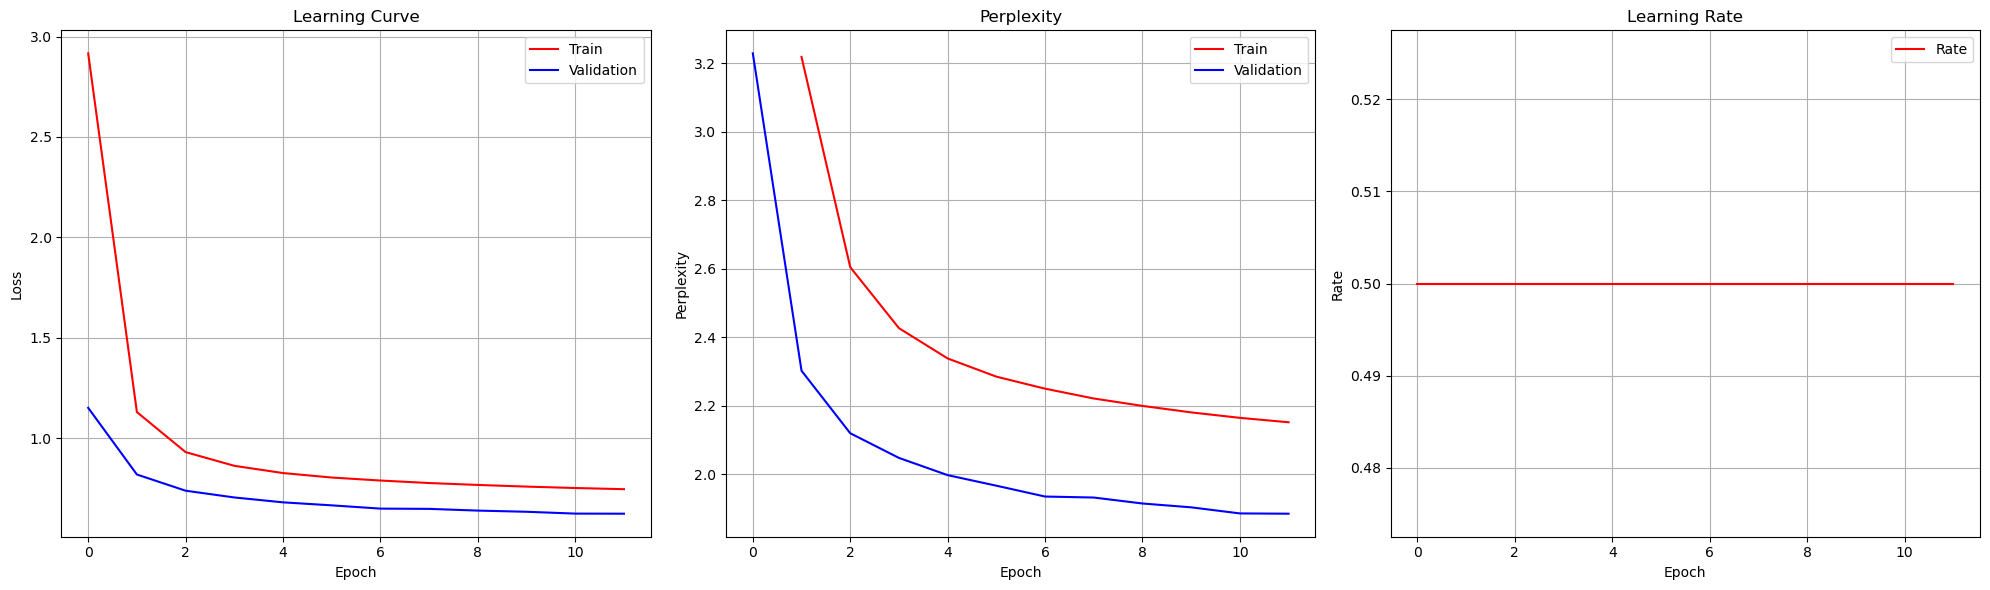

In [18]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [19]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

/tmp/ipykernel_4181/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


Validation: Loss = 0.6236 , Perplexity = 1.885
Test: Loss = 0.6493 , Perplexity = 1.942


# Text Generation

In [20]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(267735, 700)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(700, 700, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(700, 700, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(700, 700, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=700, out_features=267735, bias=True)
)

In [21]:
num_trainable_params(model)

386.873535

In [90]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [char2ind[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = findWordByToken(next_token_id)
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie is"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie is stealing makes under match presents who established keep heavy played cities phased witch in running Gilbert foul British familiarity accessible .
